# The traveling salesman problem (TSP)

> Given a set of cities, what is the shortest route (shortest can mean fastest, cheapest, etc.) to visit every city exactly once and return to the origin city?

## Stating the problem

The first thing to do, is get a list of cities! To do that, we'll use mapbox api. First, let's import the necesary libraries.

In [392]:
import copy
import json
import time
import random
import requests
from functools import reduce
from IPython.display import JSON
from ipyleaflet import Map, Marker, CircleMarker, Polyline
from ipywidgets import Layout
import matplotlib.pyplot as plt

Suppose that our salesman wants to visit 20 random state capitals.

In [393]:
#### We load a list of states, along with capitals and their lat/lon's
with open('us_states_data.json') as json_file:
    states = json.load(json_file)

#### We set the seed for reproductibility
random.seed(15)
states_sample = random.sample(states, 20)
JSON([state['capital'] for state in states_sample])

<IPython.core.display.JSON object>

Now, our salesman can start from anyware, so we'll choose a random capital:

In [394]:
random.seed(10)
start_state = random.sample(states_sample, 1)[0]
display(start_state['capital'])

'Oklahoma City'

All right! Now let's look in a map where is our salesman going!

In [395]:
#### We calculate the geometric center of the landmarks
center = tuple(
    sum(x)/len(x) for x in zip(*[ [state['lat'], state['lon']] for state in states_sample ])
)
#### We create the map
m = Map(
    center=center,
    zoom=3,
    layout=Layout(width='800px', height='500px')
)

#### We crate the markers 
markers = [
    CircleMarker(
        location=(state['lat'], state['lon']), #### We invert lat/lon order for compatibility
        title=state['capital'],
        draggable=False,
        radius = 2
    ) for state in states_sample
]
start_marker = CircleMarker(
    location = (start_state['lat'], start_state['lon']),
    radius = 10,
    color = "red",
    fill_color = "red"
)

#### We add the markers to the map
[m.add_layer(marker) for marker in markers]
m.add_layer(start_marker)

#### We display the map
display(m)

Map(center=[38.8885877, -94.88133620000002], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

What can we do now? Well, we could start by choosing some random routes, and see how well they perform. Befor we do so, let's clarify what do we mean by "route":
> A route will be a closed path of straigh lines that join all capitals toghether

Of course, this isn't very realistic, but we could imporve our definition to be more suited for the real world (actual roads, for example). We'll stick to this definition for now.

We'll be drawing a lot of maps, so let's wrap this procedure into a function before continuing.

In [396]:
def draw_map(states, route=None, start_state=None):
    """The map drawing function"""
    center = tuple(
        sum(x)/len(x) for x in zip(*[ [state['lat'], state['lon']] for state in states ])
    )

    m = Map(
        center=center,
        zoom=3,
        layout=Layout(width='800px', height='500px')
    )
    
    if route is not None:
        route_path = Polyline(
            locations=[
                [ state['lat'], state['lon'] ] for state in route['route']
            ],
            color="red",
            fill=False,
            weight = 2,
        )
        m.add_layer(route_path)
    
    if start_state is not None:
        start_marker = CircleMarker(
            location = (start_state['lat'], start_state['lon']),
            radius = 10,
            color = "green",
            fill_color = "green"
        )
        m.add_layer(start_marker)
    
    markers = [
        CircleMarker(
            location=(state['lat'], state['lon']), #### We invert lat/lon order for compatibility
            title=state['capital'],
            draggable=False,
            radius = 2,
        ) for state in states
    ]    
    [m.add_layer(marker) for marker in markers]
        
    display(m)

## Lots of routes

Let's build a random route and see how well performs

In [445]:
random.seed(15)
route = {}
route['route'] = [start_state] + [state for state in random.sample(states_sample, 20) if state['name'] != start_state['name']] + [start_state]

draw_map(states_sample, start_state=start_state, route=route)

Map(center=[38.8885877, -94.88133620000002], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

It seems like a very complicated route. Let's calculate it's absolute value distance (for speed)

In [446]:
def distance(route):
    return sum(list(map(lambda x, y: abs(x['lat'] - y['lat']) + abs(x['lon'] - y['lon']), route[:-1], route[1:])))

print('Route distance: {:.2f}'.format(distance(route['route'])))

Route distance: 662.39


This distance is not in length units, but is a distance nontheles. This means it can serve as score on how good our route is.

Let's build 10,000 routes, and see how low can we take the distance.

In [447]:
random_routes = []
for i in range(0,10000):
    route = [start_state] + [state for state in random.sample(states_sample, 20) if state['name'] != start_state['name']] + [start_state]
    random_routes.append(
        {
            'index': i,
            'route': route,
            'distance' : distance(route)
        }
    )
random_routes.sort(key=lambda x: x['distance'])

print('Shortest route distance: {:.2f}'.format(distance(random_routes[0]['route'])))

Shortest route distance: 391.90


Let's see the shortes route

In [448]:
draw_map(states_sample, start_state=start_state, route=random_routes[0])

Map(center=[38.8885877, -94.88133620000002], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

Surely looks better. Let's see how the distance is distributed among our random sample.

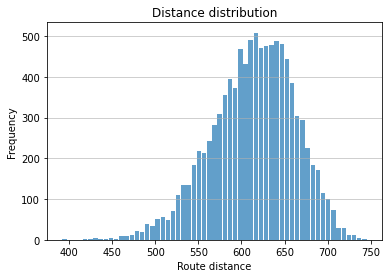

In [449]:
random_routes_dist = [route['distance'] for route in random_routes]
plt.hist(
    random_routes_dist,
    bins='auto',
    alpha=0.7,
    rwidth=0.85
)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Route distance')
plt.ylabel('Frequency')
plt.title('Distance distribution')
plt.show()

By the look of it, it seems that we surely got a good route but, is there room for improvement?

## Random swaps

The problem with the above approach is that we might do better sampling of the configuration space. Let's try improving the routes in the following way:
1. Take our 100 best scored routes.
2. Measure the total distance.
3. Swap two random capitals.
4. Measure the total distance.
5. If it improves, keep the swap. If not, reverse the swap.
6. Repeat until threshold

So, let's get to work.

In [450]:
#### We choose a random route
random.seed(15)
idx = random.sample(range(0,100),1)[0]
swap_candidate_route = dict(random_routes[idx])
display(swap_candidate_route['distance'])

463.844294

There is room for improvement

In [451]:
current_route = copy.deepcopy(swap_candidate_route)
print('Current distance: {}'.format(distance(current_route['route'])))

for i in range(0, 10000): #### We try 5000 random swaps. This also could be handled by a threshold
    idx = range(1, len(current_route['route'])-1)
    i1, i2 = random.sample(idx, 2)
    random_swap = copy.deepcopy(current_route)
    random_swap['route'][i1], random_swap['route'][i2] = random_swap['route'][i2], random_swap['route'][i1]
    random_swap['distance'] = distance(random_swap['route'])
    
    if random_swap['distance'] < current_route['distance']:
        current_route = copy.deepcopy(random_swap)
        
print('Final distance: {}'.format(distance(current_route['route'])))

Current distance: 463.844294
Final distance: 324.79308


#### Great!

Let's run it on our previously calculated set and see what happens.

In [454]:
top_random_routes = copy.deepcopy(random_routes[:100])

swaped_routes = []
for jdx, route in enumerate(top_random_routes):
    current_route = copy.deepcopy(route)
    if jdx % 10 == 0:
        print('{}.\tCurrent distance: {:.2f}'.format(jdx, current_route['distance']))
    for i in range(0, 10000):
        idx = range(1, len(current_route['route'])-1)
        i1, i2 = random.sample(idx, 2)
        random_swap = copy.deepcopy(current_route)
        random_swap['route'][i1], random_swap['route'][i2] = random_swap['route'][i2], random_swap['route'][i1]
        random_swap['distance'] = distance(random_swap['route'])

        if random_swap['distance'] < current_route['distance']:
            current_route = copy.deepcopy(random_swap)
            
    swaped_routes.append(current_route)
    if jdx % 10 == 0:
        print(' \tImproved distance: {:.2f}'.format(current_route['distance']))
    

swaped_routes.sort(key=lambda x: x['distance'])

print('Best route: {:.2f}'.format(distance(swaped_routes[0]['route'])))
draw_map(states_sample, start_state=start_state, route=swaped_routes[0])

0.	Current distance: 391.90
 	Improved distance: 318.85
10.	Current distance: 447.11
 	Improved distance: 326.04
20.	Current distance: 461.47
 	Improved distance: 323.92
30.	Current distance: 466.49
 	Improved distance: 285.18
40.	Current distance: 472.26
 	Improved distance: 300.09
50.	Current distance: 476.32
 	Improved distance: 313.00
60.	Current distance: 479.39
 	Improved distance: 322.60
70.	Current distance: 481.73
 	Improved distance: 292.77
80.	Current distance: 484.45
 	Improved distance: 364.30
90.	Current distance: 487.87
 	Improved distance: 325.65
Best route: 277.87


Map(center=[38.8885877, -94.88133620000002], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

### This is fantastic!

Let's take a look at our swaped distance distribution, and compare it with our swaped random one (due to different distribution sizes, we normalize it first).

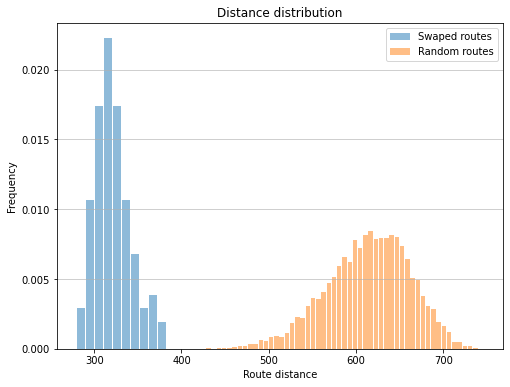

In [453]:
swaped_routes_dist = [route['distance'] for route in swaped_routes]
plt.figure(figsize=(8,6))
plt.hist(
    [route['distance'] for route in swaped_routes],
    bins='auto',
    alpha=0.5,
    rwidth=0.85,
    label = 'Swaped routes',
    density = True
)
plt.hist(
    random_routes_dist,
    bins='auto',
    alpha=0.5,
    rwidth=0.85,
    label = 'Random routes',
    density = 'True'
)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Route distance')
plt.ylabel('Frequency')
plt.title('Distance distribution')
plt.legend(loc='upper right')
plt.show()

From this histogram, and the route itself, we can see that **we've reached the global minimum**.

## What if our salesman wants to go to all 50 states?

First of all, we can pack our procedures into functions in order to streamline them.

In [406]:
def random_routes_generator(states, start_state, n=100):
    """Function to generate and sort random routes from best to worst"""
    random_routes = []
    for i in range(0,n):
        route = [start_state] + [state for state in random.sample(states, len(states)) if state['name'] != start_state['name']] + [start_state]
        random_routes.append(
            {
                'index': i,
                'route': route,
                'distance' : distance(route)
            }
        )
    
    random_routes.sort(key=lambda x: x['distance'])
    return random_routes

def route_rand_refiner(route, n=100): 
    """
    It randomly 'mutates' the route to see if there is room for improvement
    
    @todo: add score change or max time threshold
    @todo: best to work with tuples and avoid all this deep copy!
    
    """
    
    current_route = copy.deepcopy(route)
    for i in range(0, n): #### We try 5000 random swaps. This also could be handled by a threshold
        idx = range(1, len(current_route['route'])-1)
        i1, i2 = random.sample(idx, 2)
        random_swap = copy.deepcopy(current_route)
        random_swap['route'][i1], random_swap['route'][i2] = random_swap['route'][i2], random_swap['route'][i1]
        random_swap['distance'] = distance(random_swap['route'])

        if random_swap['distance'] < current_route['distance']:
            current_route = copy.deepcopy(random_swap)
    return current_route

def draw_histogram(routes_samples, label='Sample distances', density=False):
    plt.figure(figsize=(8,6))
    
    if any(isinstance(el, list) for el in routes_samples):
        for idx, routes in enumerate(routes_samples):
            if label == 'Sample distances':
                hist_label = 'Sample distances {}'.format(idx)
            else:
                hist_label = label
            routes_distances = [route['distance'] for route in routes]    
            plt.hist(
                routes_distances,
                bins='auto',
                alpha=0.5,
                rwidth=0.85,
                density = density,
                label = hist_label
            )
    else:
        routes_distances = [route['distance'] for route in routes_samples]    
        hist_label = label
        plt.hist(
            routes_distances,
            bins='auto',
            alpha=0.5,
            rwidth=0.85,
            density = True,
            label = hist_label
        )
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Route distance')
    plt.ylabel('Frequency')
    plt.title('Distance distribution')
    plt.legend(loc='upper right')
    plt.show()
    

We are ready!

First, we generate our random routes.

Map(center=[39.450730374, -93.46520434000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

Best distance: 999.1837405999997


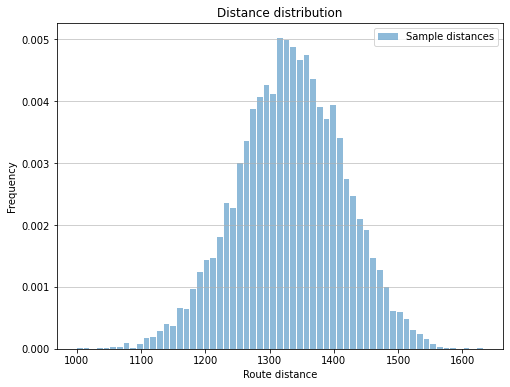

In [407]:
routes = random_routes_generator(states, start_state, n=10000)

draw_map(states, start_state=start_state, route=routes[0])
print('Best distance: {}'.format(routes[0]['distance']))
draw_histogram(routes)

Next, let's do our random 'mutations'

In [408]:
top_routes = copy.deepcopy(routes[:100])

refined_routes = []
for jdx, route in enumerate(top_routes):
    current_route = copy.deepcopy(route)
    refined_route = route_rand_refiner(current_route, n=10000)
    if jdx % 10 == 0:
        print('{}.\tCurrent distance: {:.2f}'.format(jdx, current_route['distance']))
        print(' \tRefined distance: {:.2f}'.format(refined_route['distance']))
        
    refined_routes.append(refined_route)   

refined_routes.sort(key=lambda x: x['distance'])

print('Best route: {:.2f}'.format(refined_routes[0]['distance']))

0.	Current distance: 999.18
 	Refined distance: 481.30
10.	Current distance: 1071.63
 	Refined distance: 491.43
20.	Current distance: 1089.68
 	Refined distance: 505.99
30.	Current distance: 1103.48
 	Refined distance: 489.21
40.	Current distance: 1109.78
 	Refined distance: 491.96
50.	Current distance: 1118.14
 	Refined distance: 541.40
60.	Current distance: 1121.50
 	Refined distance: 483.48
70.	Current distance: 1125.86
 	Refined distance: 470.07
80.	Current distance: 1129.43
 	Refined distance: 441.92
90.	Current distance: 1132.59
 	Refined distance: 465.36
Best route: 409.12


Map(center=[39.450730374, -93.46520434000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

Best distance: 409.11710260000007


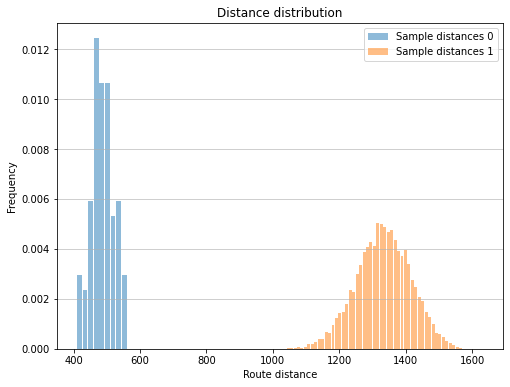

In [409]:
draw_map(states, start_state=start_state, route=refined_routes[0])
print('Best distance: {}'.format(refined_routes[0]['distance']))
draw_histogram([refined_routes, routes], density=True)

### A fantastic improvement!
### But...

...due the number of states, is not clear that we've reached the global minimun, which leads to the question 'Can we improve some more?'

Let's thought of what we did:
1. We choose some routes at random
2. We picked the 100 best ones and droped the rest
3. We 'mutated' at random every route and if the mutation improved the route, we kept it and if it didn't, we discarded it.

So, a couple of questions can be made:
* Why mutate in every step?
* Do one mutation leads to an inescapable evolutionary path?
* If so, how can I combine two different paths?

## Genetic algorithms

The idea behind genetic algorithms is to be able to *mutate* solutions as we did before, but also to do *crossover* between them.

How are we going to achieve this? Well, we are going to define a *gene* as a three state tuple in our route sequence. Then we are going to randomly choose two routes and introduce a *gene* from one route to the other. If the *offspring* has better health, we keep it; if not, we discard it.

First, let's choose two parents at random

In [410]:
random.seed(16)
parents = random.sample(refined_routes, 2)

print('Parent 0 distance: {:.2f}'.format(parents[0]['distance']))
draw_map(states, start_state=start_state, route=parents[0])
print('Parent 1 distance: {:.2f}'.format(parents[1]['distance']))
draw_map(states, start_state=start_state, route=parents[1])

Parent 1 distance: 483.48


Map(center=[39.450730374, -93.46520434000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

Parent 1 distance: 496.68


Map(center=[39.450730374, -93.46520434000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

To cross them over, we are going to chose a dominant *trait*, which will define a *gene*, i.e. a 3 conected cities piece of route, which in turn will go differently *expressed* (randomly swaped) into the offspring, whose sequence will be the one of the recessive parent alogn with this expresion. Also, we add a 10% chance of gene mutation.

In [411]:
i = 0
print('Parents distances: {:.2f}, {:.2f}'.format(parents[0]['distance'], parents[1]['distance']))
while i < 10000:  #### We try 10000 to produce better offspring
    random.seed(i) #### For reproductibility
    #### Select the dominant trait
    dom = random.sample((0,1),1)[0]
    trait = random.sample(range(2, len(parents[dom]['route'])-2),1)[0] #### We need to excercise care around the start/end of the route
    #### Get the gene
    gene = parents[dom]['route'][trait-1:trait+2]
    #### Drop recesive gene
    offspring = copy.deepcopy(parents[1-dom])
    offspring['route'] = [state for state in offspring['route'] if state not in gene]
    #### Rearrange the gene
    new_gene = random.sample(gene, 3)
    ### Select a random place to insert the new gene
    idx = random.sample(range(1,len(offspring['route'])-1),1)[0]
    new_offspring = copy.deepcopy(offspring)
    new_offspring['route'] = offspring['route'][:idx] + new_gene + offspring['route'][idx:]
    #### 10% chance of mutation
    mutation_chance = random.uniform(0, 1)
    if mutation_chance <= 0.1:
        idx1, idx2 = random.sample(range(2,len(new_offspring['route'])-2),2)
        new_offspring['route'][idx1-1], new_offspring['route'][idx2-1] = new_offspring['route'][idx2-1], new_offspring['route'][idx1-1]
        new_offspring['route'][idx1], new_offspring['route'][idx2] = new_offspring['route'][idx2], new_offspring['route'][idx1]
        new_offspring['route'][idx1+1], new_offspring['route'][idx2+1] = new_offspring['route'][idx2+1], new_offspring['route'][idx1+1]
    new_offspring['distance'] = distance(new_offspring['route'])
    #### Did new_offspring got better health?    
    if (new_offspring['distance'] < parents[0]['distance']) & (new_offspring['distance'] < parents[1]['distance']):
        offspring = copy.deepcopy(new_offspring)
        print('Offspring distance: {:.2f}'.format(offspring['distance']))
        break
    else:
        i += 1
        
draw_map(states, start_state=start_state, route=new_offspring)

Parents distances: 483.48, 496.68
Offspring distance: 480.36


Map(center=[39.450730374, -93.46520434000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

We can see the offspring looks like parent 1 and improves travel in the east cost. Let's do one generation and see if we get a better offsrping.

Best parent distance: 409.11710260000007
Best offsprint distance: 400.1099940000001


Map(center=[39.450730374, -93.46520434000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

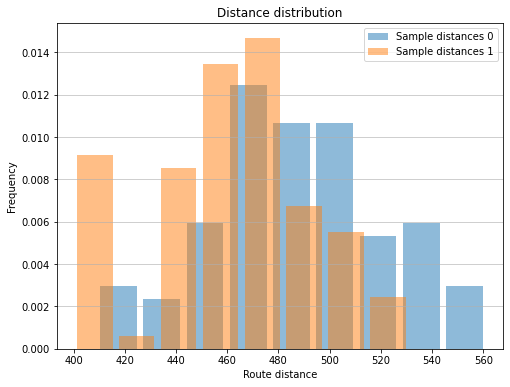

In [412]:
next_generation = []
while len(next_generation) < 100:
    i = 0
    parents = random.sample(refined_routes, 2)
    while i < 10000: 
        #### Select the dominant trait
        dom = random.sample((0,1),1)[0]
        trait = random.sample(range(2, len(parents[dom]['route'])-2),1)[0] #### We need to excercise care around the start/end of the route
        #### Get the gene
        gene = parents[dom]['route'][trait-1:trait+2]
        #### Drop recesive gene
        offspring = copy.deepcopy(parents[1-dom])
        offspring['route'] = [state for state in offspring['route'] if state not in gene]
        #### Rearrange the gene
        new_gene = random.sample(gene, 3)
        ### Select a random place to insert the new gene
        idx = random.sample(range(1,len(offspring['route'])-1),1)[0]
        new_offspring = copy.deepcopy(offspring)
        new_offspring['route'] = offspring['route'][:idx] + new_gene + offspring['route'][idx:]
        #### 10% chance of mutation
        mutation_chance = random.uniform(0, 1)
        if mutation_chance <= 0.1:
            idx1, idx2 = random.sample(range(2,len(new_offspring['route'])-2),2)
            new_offspring['route'][idx1-1], new_offspring['route'][idx2-1] = new_offspring['route'][idx2-1], new_offspring['route'][idx1-1]
            new_offspring['route'][idx1], new_offspring['route'][idx2] = new_offspring['route'][idx2], new_offspring['route'][idx1]
            new_offspring['route'][idx1+1], new_offspring['route'][idx2+1] = new_offspring['route'][idx2+1], new_offspring['route'][idx1+1]
        new_offspring['distance'] = distance(new_offspring['route'])
        #### Did new_offspring got better health?    
        if (new_offspring['distance'] < parents[0]['distance']) & (new_offspring['distance'] < parents[1]['distance']):
            next_generation.append(new_offspring)
            break
        else:
            i += 1
        
next_generation.sort(key=lambda x: x['distance'])
print('Best parent distance: {}'.format(refined_routes[0]['distance']))
print('Best offsprint distance: {}'.format(next_generation[0]['distance']))
draw_map(states, start_state=start_state, route=next_generation[0])
draw_histogram([refined_routes, next_generation], density=True)

We did improve overall route distance, but we lost some of our finests. Thats because by choosing randomly, we are heavily drawn to pick from the mean of the parents distribution.

One last step would be to have a better chance of choosing low scoring parents. We could do this using the distances distribution, but we'll keep it simple for now and just give a 50% chance of choosing the best 20 routes, 10% chance of choosing the worst 20, and a 40% chance to choose every other route.

Best parent distance: 409.11710260000007
Best offsprint distance: 402.84626260000005


Map(center=[39.450730374, -93.46520434000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

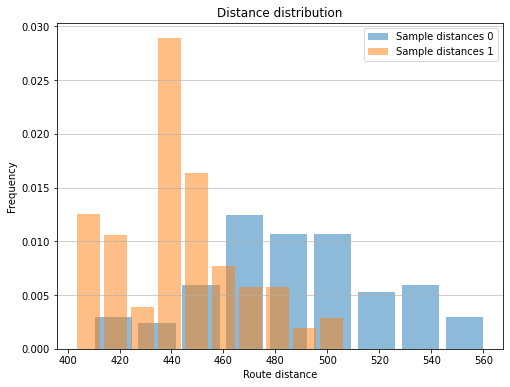

In [413]:
chosen_generation = []
while len(chosen_generation) < 100:
    i = 0
    chances = [random.random(), random.random()]
    parents = []
    for chance in chances:
        if chance <= 0.5:
            parents.append(
                random.sample(
                    [ route for route in refined_routes[:20] if route not in parents ],
                    1
                )[0]
            )
        elif (0.5 < chance) & (chance <= 0.9):
            parents.append(
                random.sample(
                    [ route for route in refined_routes[20:90] if route not in parents ],
                    1
                )[0]
            )
        else:
            parents.append(
                random.sample(
                    [ route for route in refined_routes[90:] if route not in parents ],
                    1
                )[0]
            )
    while i < 10000:
        #### 2 geene passing
        #### Select the dominant trait
        dom = random.sample((0,1),1)[0]
        trait = random.sample(range(2, len(parents[dom]['route'])-2),1)[0] #### We need to excercise care around the start/end of the route
        #### Get the gene
        gene = parents[dom]['route'][trait-1:trait+2]
        #### Drop recesive gene
        offspring = copy.deepcopy(parents[1-dom])
        offspring['route'] = [state for state in offspring['route'] if state not in gene]
        #### Rearrange the gene
        new_gene = random.sample(gene, 3)
        ### Select a random place to insert the new gene
        idx = random.sample(range(1,len(offspring['route'])-1),1)[0]
        new_offspring = copy.deepcopy(offspring)
        new_offspring['route'] = offspring['route'][:idx] + new_gene + offspring['route'][idx:]
        #### 10% chance of mutation
        mutation_chance = random.uniform(0, 1)
        if mutation_chance <= 0.1:
            idx1, idx2 = random.sample(range(2,len(new_offspring['route'])-2),2)
            new_offspring['route'][idx1-1], new_offspring['route'][idx2-1] = new_offspring['route'][idx2-1], new_offspring['route'][idx1-1]
            new_offspring['route'][idx1], new_offspring['route'][idx2] = new_offspring['route'][idx2], new_offspring['route'][idx1]
            new_offspring['route'][idx1+1], new_offspring['route'][idx2+1] = new_offspring['route'][idx2+1], new_offspring['route'][idx1+1]
        new_offspring['distance'] = distance(new_offspring['route'])
        #### Did new_offspring got better health?    
        if (new_offspring['distance'] < parents[0]['distance']) & (new_offspring['distance'] < parents[1]['distance']):
            chosen_generation.append(new_offspring)
            break
        else:
            i += 1
        
chosen_generation.sort(key=lambda x: x['distance'])
print('Best parent distance: {}'.format(refined_routes[0]['distance']))
print('Best offsprint distance: {}'.format(chosen_generation[0]['distance']))
draw_map(states, start_state=start_state, route=chosen_generation[0])
draw_histogram([refined_routes, chosen_generation], density=True)

This distribution suggests that we are getting closer to the global minimum. Let's try to do some more generations, where, to avoid inbreeding, we are droping the 10% least fitted routes and introducing 5% fully random and 5% refined foreing routes to the pool on each generation.

In [414]:
generations = []
pool = copy.deepcopy(chosen_generation[:90])
pool = pool + random_routes_generator(states, start_state, n=5) + [
    route_rand_refiner(route, n=10000) for route in random_routes_generator(states, start_state, n=5)
]
pool.sort(key=lambda x: x['distance'])
for jdx in range(0, 10):
    generation = []
    while len(generation) < 100:
        i = 0
        chances = [random.random(), random.random()]
        parents = []
        for chance in chances:
            if chance <= 0.5:
                parents.append(
                    random.sample(
                        [ route for route in pool[:20] if route not in parents ],
                        1
                    )[0]
                )
            elif (0.5 < chance) & (chance <= 0.9):
                parents.append(
                    random.sample(
                        [ route for route in pool[20:90] if route not in parents ],
                        1
                    )[0]
                )
            else:
                parents.append(
                    random.sample(
                        [ route for route in pool[90:] if route not in parents ],
                        1
                    )[0]
                )
        while i < 10000: 
            #### Select the dominant trait
            dom = random.sample((0,1),1)[0]
            trait = random.sample(range(2, len(parents[dom]['route'])-2),1)[0] #### We need to excercise care around the start/end of the route
            #### Get the gene
            gene = parents[dom]['route'][trait-1:trait+2]
            #### Drop recesive gene
            offspring = copy.deepcopy(parents[1-dom])
            offspring['route'] = [state for state in offspring['route'] if state not in gene]
            #### Rearrange the gene
            new_gene = random.sample(gene, 3)
            ### Select a random place to insert the new gene
            idx = random.sample(range(1,len(offspring['route'])-1),1)[0]
            new_offspring = copy.deepcopy(offspring)
            new_offspring['route'] = offspring['route'][:idx] + new_gene + offspring['route'][idx:]
            #### 20% chance of mutation
            mutation_chance = random.uniform(0, 1)
            if mutation_chance <= 0.2:
                idx1, idx2 = random.sample(range(2,len(new_offspring['route'])-2),2)
                new_offspring['route'][idx1-1], new_offspring['route'][idx2-1] = new_offspring['route'][idx2-1], new_offspring['route'][idx1-1]
                new_offspring['route'][idx1], new_offspring['route'][idx2] = new_offspring['route'][idx2], new_offspring['route'][idx1]
                new_offspring['route'][idx1+1], new_offspring['route'][idx2+1] = new_offspring['route'][idx2+1], new_offspring['route'][idx1+1]
            new_offspring['distance'] = distance(new_offspring['route'])
            #### Did new_offspring got better health?    
            if (new_offspring['distance'] < parents[0]['distance']) & (new_offspring['distance'] < parents[1]['distance']):
                generation.append(new_offspring)
                break
            else:
                i += 1
    
    generation.sort(key=lambda x: x['distance'])
    generations.append(generation)
    
    pool = copy.deepcopy(generation[:90])
    pool = pool + random_routes_generator(states, start_state, n=5) + [
        route_rand_refiner(route, n=10000) for route in random_routes_generator(states, start_state, n=5)
    ]
    pool.sort(key=lambda x: x['distance'])
    print('{}. Best offsrping: {:.2f}'.format(len(generations), distance(generation[0]['route'])))

1. Best offsrping: 394.31
2. Best offsrping: 386.19
3. Best offsrping: 379.92
4. Best offsrping: 376.50
5. Best offsrping: 373.91
6. Best offsrping: 371.77
7. Best offsrping: 370.71
8. Best offsrping: 370.28
9. Best offsrping: 366.72
10. Best offsrping: 365.41


Map(center=[39.450730374, -93.46520434000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

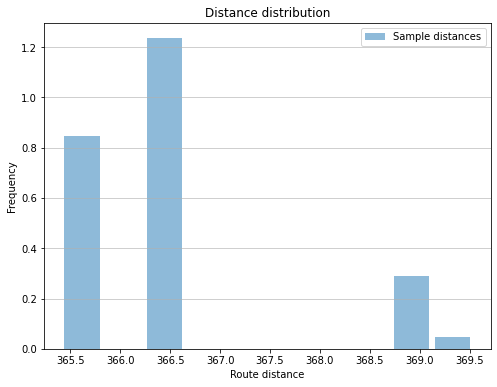

In [468]:
draw_map(states, start_state=start_state, route=generations[-1][0])
draw_histogram(generations[-1])

This is gantastic. Altough, there is a cross there in the midwest that is bothering me, and it has been passed from generation to generation. This shows how inbreeding works. Let's see if we can get rid of it with a fresh new pool.

This time, we're not doing any swaping, just to let the genetic algorithm perform.

In [459]:
parallel_generations = []

pool = random_routes_generator(states, start_state, n=100)

pool.sort(key=lambda x: x['distance'])
for jdx in range(0, 10):
    generation = []
    while len(generation) < 100:
        i = 0
        chances = [random.random(), random.random()]
        parents = []
        for chance in chances:
            if chance <= 0.5:
                parents.append(
                    random.sample(
                        [ route for route in pool[:20] if route not in parents ],
                        1
                    )[0]
                )
            elif (0.5 < chance) & (chance <= 0.9):
                parents.append(
                    random.sample(
                        [ route for route in pool[20:90] if route not in parents ],
                        1
                    )[0]
                )
            else:
                parents.append(
                    random.sample(
                        [ route for route in pool[90:] if route not in parents ],
                        1
                    )[0]
                )
        while i < 10000: 
            #### Select the dominant trait
            dom = random.sample((0,1),1)[0]
            trait = random.sample(range(2, len(parents[dom]['route'])-2),1)[0] #### We need to excercise care around the start/end of the route
            #### Get the gene
            gene = parents[dom]['route'][trait-1:trait+2]
            #### Drop recesive gene
            offspring = copy.deepcopy(parents[1-dom])
            offspring['route'] = [state for state in offspring['route'] if state not in gene]
            #### Rearrange the gene
            new_gene = random.sample(gene, 3)
            ### Select a random place to insert the new gene
            idx = random.sample(range(1,len(offspring['route'])-1),1)[0]
            new_offspring = copy.deepcopy(offspring)
            new_offspring['route'] = offspring['route'][:idx] + new_gene + offspring['route'][idx:]
            #### 20% chance of mutation
            mutation_chance = random.uniform(0, 1)
            if mutation_chance <= 0.2:
                idx1, idx2 = random.sample(range(2,len(new_offspring['route'])-2),2)
                new_offspring['route'][idx1-1], new_offspring['route'][idx2-1] = new_offspring['route'][idx2-1], new_offspring['route'][idx1-1]
                new_offspring['route'][idx1], new_offspring['route'][idx2] = new_offspring['route'][idx2], new_offspring['route'][idx1]
                new_offspring['route'][idx1+1], new_offspring['route'][idx2+1] = new_offspring['route'][idx2+1], new_offspring['route'][idx1+1]
            new_offspring['distance'] = distance(new_offspring['route'])
            #### Did new_offspring got better health?    
            if (new_offspring['distance'] < parents[0]['distance']) & (new_offspring['distance'] < parents[1]['distance']):
                generation.append(new_offspring)
                break
            else:
                i += 1
    
    generation.sort(key=lambda x: x['distance'])
    parallel_generations.append(generation)
    
    pool = copy.deepcopy(generation[:90])
    pool = pool + random_routes_generator(states, start_state, n=5) + [
        route_rand_refiner(route, n=10000) for route in random_routes_generator(states, start_state, n=5)
    ]
    pool.sort(key=lambda x: x['distance'])
    print('{}. Best offsrping: {:.2f}'.format(len(parallel_generations), distance(generation[0]['route'])))

1. Best offsrping: 1089.01
2. Best offsrping: 473.23
3. Best offsrping: 438.52
4. Best offsrping: 429.02
5. Best offsrping: 422.90
6. Best offsrping: 406.11
7. Best offsrping: 400.94
8. Best offsrping: 393.47
9. Best offsrping: 386.84
10. Best offsrping: 384.39


Map(center=[39.450730374, -93.46520434000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

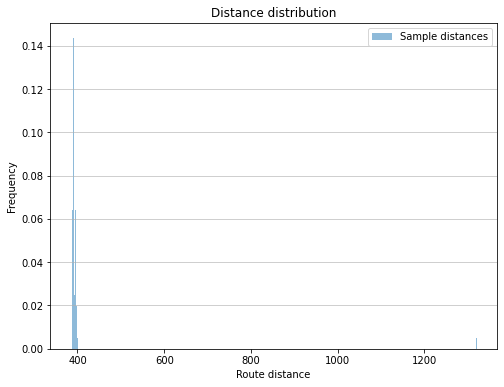

In [460]:
draw_map(states, start_state=start_state, route=parallel_generations[-1][0])
draw_histogram(parallel_generations[-1])

This parallel path is not as fit as the previous one, but it might have the genetic diversity needed to correct the cross defect. Let's build a new pool and generate new offspring. This time, we give 1/2 chance to pick from one pool vs. 1/2 to pick from the other. To prevent stagnation, we take the 3rd generation from each pool.

In [531]:
crossover_generations = []

pool_0 = generations[2]
pool_1 = parallel_generations[2]

for jdx in range(0, 10):
    generation = []
    while len(generation) < 100:
        i = 0
        if jdx ==0:
            parents = [random.sample(pool_0, 1)[0], random.sample(pool_1, 1)[0]]
        else:
            parents = random.sample(pool, 2)    
        while i < 10000: 
            #### Select the dominant trait
            dom = random.sample((0,1),1)[0]
            trait = random.sample(range(2, len(parents[dom]['route'])-2),1)[0] #### We need to excercise care around the start/end of the route
            #### Get the gene
            gene = parents[dom]['route'][trait-1:trait+2]
            #### Drop recesive gene
            offspring = copy.deepcopy(parents[1-dom])
            offspring['route'] = [state for state in offspring['route'] if state not in gene]
            #### Rearrange the gene
            new_gene = random.sample(gene, 3)
            ### Select a random place to insert the new gene
            idx = random.sample(range(1,len(offspring['route'])-1),1)[0]
            new_offspring = copy.deepcopy(offspring)
            new_offspring['route'] = offspring['route'][:idx] + new_gene + offspring['route'][idx:]
            #### 50% chance of mutation
            mutation_chance = random.uniform(0, 1)
            if mutation_chance <= 0.5:
                idx1, idx2 = random.sample(range(2,len(new_offspring['route'])-2),2)
                new_offspring['route'][idx1-1], new_offspring['route'][idx2-1] = new_offspring['route'][idx2-1], new_offspring['route'][idx1-1]
                new_offspring['route'][idx1], new_offspring['route'][idx2] = new_offspring['route'][idx2], new_offspring['route'][idx1]
                new_offspring['route'][idx1+1], new_offspring['route'][idx2+1] = new_offspring['route'][idx2+1], new_offspring['route'][idx1+1]
            new_offspring['distance'] = distance(new_offspring['route'])
            #### Did new_offspring got better health?    
            if (new_offspring['distance'] < parents[0]['distance']) & (new_offspring['distance'] < parents[1]['distance']):
                generation.append(new_offspring)
                break
            else:
                i += 1
    
    generation.sort(key=lambda x: x['distance'])
    crossover_generations.append(generation)
    
    pool = copy.deepcopy(generation[:80])
    pool = pool + [
        route_rand_refiner(route, n=10000) for route in random_routes_generator(states, start_state, n=20)
    ]
    pool.sort(key=lambda x: x['distance'])
    print('{}. Best offsrping: {:.2f}'.format(len(crossover_generations), distance(generation[0]['route'])))

1. Best offsrping: 377.79
2. Best offsrping: 375.24
3. Best offsrping: 372.65
4. Best offsrping: 370.59
5. Best offsrping: 369.28
6. Best offsrping: 365.62
7. Best offsrping: 364.44
8. Best offsrping: 364.05
9. Best offsrping: 358.00
10. Best offsrping: 355.68


Map(center=[39.450730374, -93.46520434000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

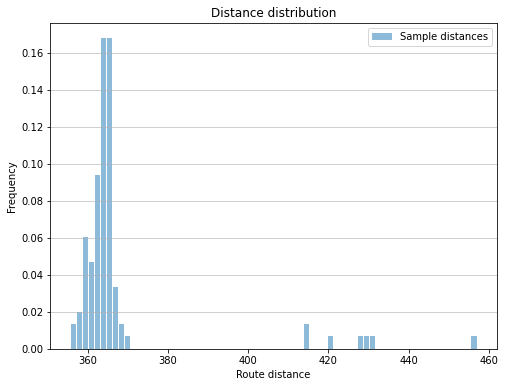

In [533]:
draw_map(states, start_state=start_state, route=crossover_generations[-1][0])
draw_histogram(crossover_generations[-1])

The cross is still there, but we've improved by almost ten units. Surle a pool with the desired feature would give us the desired result.

## Takeaways:
* It's better to refine the pool before starting the genetic algorithm (i.e., do some random swaping first).
* Instead of improving one pool, we should build parallel pools and keep adding foreign routes and beneficial mutations.
* Did I said parallel? This entire procedure is completely paralellizable (pySpark?). Maybe build a massive common pool where workers grab parents and deposit offsprings? Even longevity can be taken into account.

## Improvements:
* Increasing pool size can help reduce inbreeding.
* More mutations!
* More genetic load transference (50-50, maybe?)
* OOP packing